# Capstone Two - 3 Exploratory Data Analysis<a id='3'></a>

## 3.1 Contents<a id='3.1'></a>
* [3 Exploratory Data Analysis](#3)
  * [3.1 Contents](#3.1)
  * [3.2 Imports](#3.2)
  * [3.3 Load The Data](#3.3)
  * [3.4 Explore The Data](#3.4)
    * [3.4.1 Missing Values and Time Gaps](#3.4.1)
      * [3.4.1.1 Store Sales](#3.4.1.1)
      * [3.4.1.2 Daily Oil Price](#3.4.1.2)
      * [3.4.1.3 Transactions](#3.4.1.3)
      * [3.4.1.4 Holidays](#3.4.1.4)
    * [3.4.2 Merged Data](#3.4.2)
    * [3.4.3 Data Visualization](#3.4.3) 
      * [3.4.3.1 Mean Sales by Store and Product Family](#3.4.3.1)
      * [3.4.3.2 Mean Sales by Year and Month](#3.4.3.2)
  * [3.5 Save data](#3.5)
  * [3.6 Summary](#3.6)

## 3.2 Imports<a id='3.2'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf

from library.sb_utils import save_file

## 3.3 Load The Data<a id='3.3'></a>

In [2]:
# Directory of data
input_dir = '../input_data/store-sales-time-series-forecasting/'
data_dir = '../data/'

In [3]:
# Store sales (training set)
train = pd.read_csv(input_dir+'train.csv')

# Store sales (testing set)
test = pd.read_csv(input_dir+'test.csv')

# Store metadata
stores = pd.read_csv(input_dir+'stores.csv')

# Daily oil price
oil = pd.read_csv(input_dir+'oil.csv')

# Number of daily transactions at a store
transactions = pd.read_csv(input_dir+'transactions.csv')

# Cleaned Holidays and Events data
holidays = pd.read_csv(data_dir+'holidays_events_cleaned.csv')

## 3.4 Explore The Data<a id='3.4'></a>

### 3.4.1 Missing Values and Time Gaps<a id='3.4.1'></a>

#### 3.4.1.1 Store Sales<a id='3.4.1.1'></a>

In [4]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [5]:
test.isnull().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

There're **no** missing values in the training and test sets.

In [6]:
train[['store_nbr','family']].value_counts()

store_nbr  family                 
1          AUTOMOTIVE                 1684
36         PREPARED FOODS             1684
37         CLEANING                   1684
           CELEBRATION                1684
           BREAD/BAKERY               1684
                                      ... 
18         PREPARED FOODS             1684
           POULTRY                    1684
           PLAYERS AND ELECTRONICS    1684
           PET SUPPLIES               1684
54         SEAFOOD                    1684
Length: 1782, dtype: int64

In [7]:
test[['store_nbr','family']].value_counts()

store_nbr  family                 
1          AUTOMOTIVE                 16
36         PREPARED FOODS             16
37         CLEANING                   16
           CELEBRATION                16
           BREAD/BAKERY               16
                                      ..
18         PREPARED FOODS             16
           POULTRY                    16
           PLAYERS AND ELECTRONICS    16
           PET SUPPLIES               16
54         SEAFOOD                    16
Length: 1782, dtype: int64

All time series in the testing set have 16 values (16 days), so there is no time gap in the testing data.

All time series in the training set have 1684 values. We need to check whethere there were time gaps.

In [8]:
# Get dates of training set as a train_calendar
train_dates = train.date
train_dates.drop_duplicates(inplace=True)
train_calendar = pd.DataFrame(train_dates).reset_index(drop=True)
print(train_calendar.shape)
train_calendar.head()

(1684, 1)


,date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [9]:
# Check how many days are actually in the training set.
d0 = datetime.date(2013, 1, 1)
d1 = datetime.date(2017, 8, 16) # The day after the last day of training set
dd = d1 - d0 #day difference
dd

datetime.timedelta(days=1688)

We can see there are actually 1688 days during this time period, but the `calendar` only has 1684, so there should have 4 time gaps.

In [10]:
dates = pd.to_datetime(train_calendar['date'])
df_dates = pd.DataFrame(dates, columns=['date'])

# Take the diff of the date column (drop 1st row since it's undefined)
deltas = df_dates['date'].diff()[1:]

# Filter diffs (here days > 1, but could be seconds, hours, etc)
gaps = deltas[deltas > datetime.timedelta(days=1)]

# Print results
print(f'{len(gaps)} time gaps in total:')
for i, g in gaps.iteritems():
    gap_start = df_dates['date'][i-1]
    print(f'Start: {datetime.datetime.strftime(gap_start, "%Y-%m-%d")} | '
          f'Duration: {str(g.to_pytimedelta())}')

4 time gaps in total:
Start: 2013-12-24 | Duration: 2 days, 0:00:00
Start: 2014-12-24 | Duration: 2 days, 0:00:00
Start: 2015-12-24 | Duration: 2 days, 0:00:00
Start: 2016-12-24 | Duration: 2 days, 0:00:00


We indeed found 4 time gaps, which means every time series did not have these 4 days' data.

In [11]:
train[train['date'].isin(['2013-12-25','2014-12-25','2015-12-25','2016-12-25'])]

,id,date,store_nbr,family,sales,onpromotion


The normal time step is 1 day. The above "2 days" gap after every Christmas Eve (12-24) means that all stores were closed on Christmas Day (No sales data on "12-25"). We will fill the time gaps in a later section.

#### 3.4.1.2 Daily Oil Price<a id='3.4.1.2'></a>

From Data Wrangling, we know there are missings value and time gaps in the oil price data.

In [12]:
oil.head(10)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


The time gaps in tha above 10-row data are "2013-01-05 to 2013-01-06" and "2013-01-12 to 2013-01-13". It looks like there are no oil price data on the weekend. We need to verify it.

In [13]:
train_calendar['day_of_week'] = pd.to_datetime(train_calendar['date']).dt.day_name()
calendar_oil = train_calendar.merge(oil, how="left", on='date') 
calendar_oil.head(15)

,date,day_of_week,dcoilwtico
0,2013-01-01,Tuesday,NaN
1,2013-01-02,Wednesday,93.14
2,2013-01-03,Thursday,92.97
3,2013-01-04,Friday,93.12
4,2013-01-05,Saturday,NaN
5,2013-01-06,Sunday,NaN
6,2013-01-07,Monday,93.20
7,2013-01-08,Tuesday,93.21
8,2013-01-09,Wednesday,93.08
9,2013-01-10,Thursday,93.81


We can see there are indeed no oil price data for the weekends.

In [14]:
# Using the second value to fill the first missing value, and then using forward fill
calendar_oil = calendar_oil.drop('day_of_week', axis=1)
calendar_oil.iloc[0,1] = calendar_oil.iloc[1,1]
calendar_oil['dcoilwtico'].fillna(method = 'ffill', inplace = True)
calendar_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

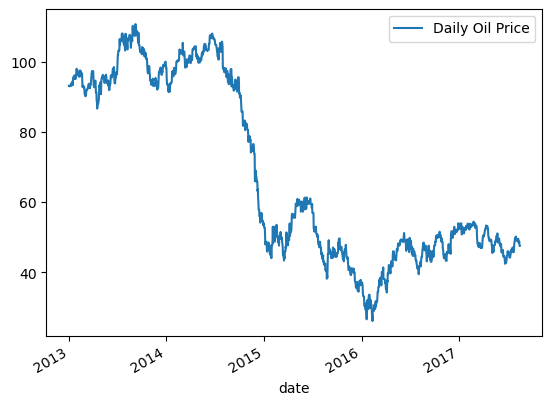

In [15]:
# Look at the oil price over the past years
oil_plt = calendar_oil
oil_plt['date'] = pd.to_datetime(oil_plt['date'])
oil_plt.plot(x = "date", y = "dcoilwtico", kind='line', label='Daily Oil Price')
plt.show()

Since Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices and the oil price fell sharply in 2014, we can try to **start our training set from "2015-01-01"**. Actually the data before this date were quite irrelevant because our target is to predict only 16 days after the training set.

#### 3.4.1.3 Transactions<a id='3.4.1.3'></a>

In [16]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [17]:
transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

There are no missing values in current tranactions data.

However, We can see there was only store No. 25 has transactions data on 2013-01-01. It means there're time gap(s) for other stores.

In order to fill the time gaps, we first merge the trian set with the store metadata, processed oil price data, and the transaction data.

In [18]:
df_train = train.merge(stores, how="left", on='store_nbr')

calendar_oil['date']=calendar_oil['date'].astype(str)
df_train = df_train.merge(calendar_oil, how="left", on='date')      

df_train = df_train.merge(transactions, how="left", on=['date','store_nbr'])  

print(df_train.shape)
df_train.head()

(3000888, 12)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,NaN


In [19]:
# Missing in transactions
df_train['transactions'].isnull().sum(), df_train['transactions'].isnull().mean()

(245784, 0.08190375648807953)

We can see there're more than 8% of the transaction data are missing after merging data sets.

With respect to transactions, we understand that since there is no data recorded for the missing value, this is 0.

In [20]:
df_train['transactions'] = df_train['transactions'].replace(np.nan,0)

In [21]:
df_train['transactions'].isnull().sum()

0

#### 3.4.1.4 Holidays<a id='3.4.1.4'></a>

We merge df_train with the holiday data.

In [22]:
df_train = df_train.merge(holidays,on='date',how='left')

# Rename cloumns with the same name
df_train = df_train.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

df_train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False


In [23]:
# Missing in merged holiday data
df_train['holiday_type'].isnull().sum(), df_train['holiday_type'].isnull().mean()

(2746062, 0.915083135391924)

We can see most of the data are missing, because most dates are not holidays.\
Replace the NaNs in `holiday_type` with "Normal", which includes normal weekdays and weekends that do not have special holidays or events.\
Replace the NaNs in `transferred` with "False".

In [24]:
df_train['holiday_type'] = df_train['holiday_type'].replace(np.nan,'Normal')
df_train['transferred'] = df_train['transferred'].replace(np.nan,False)

### 3.4.2 Merged Data<a id='3.4.2'></a>

In [25]:
# Drop the ID column
df_train = df_train.drop('id', axis=1)

df_train.head()

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,transferred
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False


Group by store number and product family:

In [26]:
grp = df_train.groupby(['store_nbr', 'family'])

### 3.4.3 Data Visualization<a id='3.4.3'></a>

#### 3.4.3.1 Mean Sales by Store and Product Family<a id='3.4.3.1'></a>

In [27]:
df_st_sa = df_train.groupby('store_type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
df_cl_sa = df_train.groupby('cluster').agg({"sales" : "mean"}).reset_index() 
df_fa_sa = df_train.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]

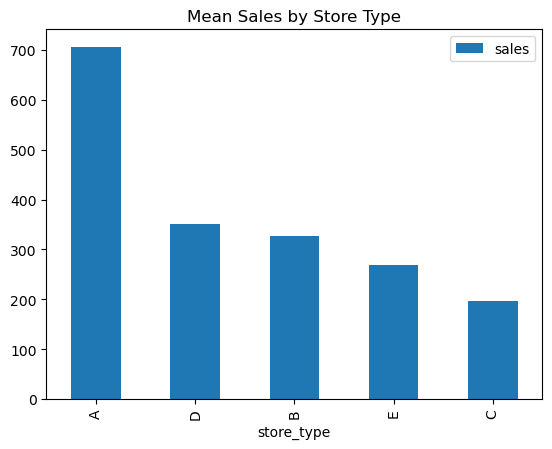

In [28]:
_ = df_st_sa.set_index('store_type').plot.bar()
_ = plt.title('Mean Sales by Store Type')

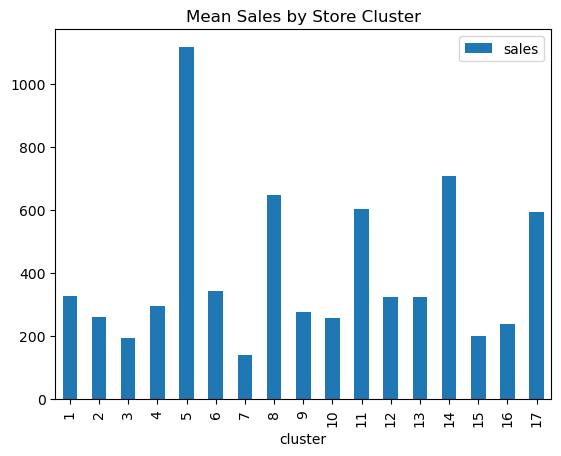

In [29]:
_ = df_cl_sa.set_index('cluster').plot.bar()
_ = plt.title('Mean Sales by Store Cluster')

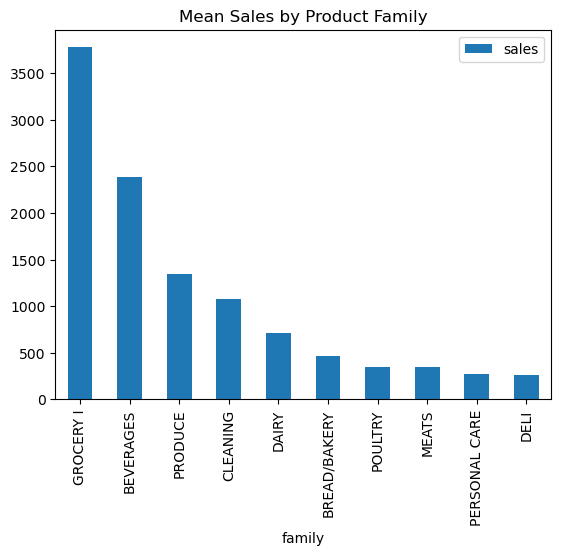

In [30]:
_ = df_fa_sa.set_index('family').plot.bar()
_ = plt.title('Mean Sales by Product Family')

Type-A and Cluster-5 stores have the highest mean sales.

Highest mean sales are made by the products like grocery and beverages. 

In [31]:
stores[ (stores['type']=='A') ]

,store_nbr,city,state,type,cluster
43,44,Quito,Pichincha,A,5
44,45,Quito,Pichincha,A,11
45,46,Quito,Pichincha,A,14
46,47,Quito,Pichincha,A,14
47,48,Quito,Pichincha,A,14
48,49,Quito,Pichincha,A,11
49,50,Ambato,Tungurahua,A,14
50,51,Guayaquil,Guayas,A,17
51,52,Manta,Manabi,A,11


In [32]:
stores[ (stores['cluster']==5) ]

,store_nbr,city,state,type,cluster
43,44,Quito,Pichincha,A,5


Only store No.44 is in both type "A" and cluster "5".

**Select one group (one time series):**

In [33]:
grp_sel = grp.get_group((44, 'GROCERY I'))

grp_sel.reset_index(inplace=True)
# grp_sel = grp_sel.set_index('date')

# Drop index, store_nbr and family columns
grp_sel = grp_sel.drop(['index', 'store_nbr', 'family', 'city', 'state', 'store_type', 'cluster'], axis=1)
grp_sel.head()

,date,sales,onpromotion,dcoilwtico,transactions,holiday_type,transferred
0,2013-01-01,0.0,0,93.14,0.0,Holiday,False
1,2013-01-02,10686.0,0,93.14,4821.0,Normal,False
2,2013-01-03,7342.0,0,92.97,3618.0,Normal,False
3,2013-01-04,7250.0,0,93.12,4169.0,Normal,False
4,2013-01-05,10699.0,0,93.12,4921.0,Work Day,False


In [34]:
grp_sel.shape

(1684, 7)

Recall that we have four time gaps on Christmas Days, and now we need to fill them up:

In [35]:
# Correct date series
start='2013-01-01'
end='2017-08-15'
df_dates = pd.DataFrame({"date": pd.date_range(start, end)})
df_dates.shape

(1688, 1)

In [36]:
# Merge sales data with correct dates
df_dates['date']=df_dates['date'].astype(str)
grp_sel_filled = grp_sel.merge(df_dates, how="right", on='date')
grp_sel_filled.shape

(1688, 7)

In [37]:
# Check Christmas Days
grp_sel_filled[grp_sel_filled['date'].isin(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'])]

,date,sales,onpromotion,dcoilwtico,transactions,holiday_type,transferred
358,2013-12-25,NaN,NaN,NaN,NaN,NaN,NaN
723,2014-12-25,NaN,NaN,NaN,NaN,NaN,NaN
1088,2015-12-25,NaN,NaN,NaN,NaN,NaN,NaN
1454,2016-12-25,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# Using forward fill
grp_sel_filled.fillna(method = 'ffill', inplace = True)

In [39]:
grp_sel_filled[grp_sel_filled['date'].isin(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'])]

,date,sales,onpromotion,dcoilwtico,transactions,holiday_type,transferred
358,2013-12-25,9081.000,0.0,98.87,7433.0,Additional,False
723,2014-12-25,10548.000,15.0,55.70,7689.0,Additional,False
1088,2015-12-25,11907.455,14.0,37.62,7700.0,Additional,False
1454,2016-12-25,15329.000,135.0,52.01,7430.0,Additional,False


In [40]:
# Get the day of week column
grp_sel_filled.date = pd.to_datetime(grp_sel_filled.date)
grp_sel_filled['day_of_week'] = grp_sel_filled['date'].dt.day_name()
grp_sel_filled.head()

,date,sales,onpromotion,dcoilwtico,transactions,holiday_type,transferred,day_of_week
0,2013-01-01,0.0,0.0,93.14,0.0,Holiday,False,Tuesday
1,2013-01-02,10686.0,0.0,93.14,4821.0,Normal,False,Wednesday
2,2013-01-03,7342.0,0.0,92.97,3618.0,Normal,False,Thursday
3,2013-01-04,7250.0,0.0,93.12,4169.0,Normal,False,Friday
4,2013-01-05,10699.0,0.0,93.12,4921.0,Work Day,False,Saturday


Add previous days' sales as predictors:

In [41]:
grp_sel_filled['sales_lag1'] = grp_sel_filled['sales'].shift(1)
grp_sel_filled['sales_lag2'] = grp_sel_filled['sales'].shift(2)
grp_sel_filled['sales_lag3'] = grp_sel_filled['sales'].shift(3)
# previous 3 days' average
grp_sel_filled['sales_3_day_avg'] = grp_sel_filled['sales_lag1'].rolling(3).mean().round(1)
# previous 7 days's average
grp_sel_filled['sales_week_avg'] = grp_sel_filled['sales_lag1'].rolling(7).mean().round(1)

In [42]:
grp_sel_filled.head(10)

,date,sales,onpromotion,dcoilwtico,transactions,holiday_type,transferred,day_of_week,sales_lag1,sales_lag2,sales_lag3,sales_3_day_avg,sales_week_avg
0,2013-01-01,0.0,0.0,93.14,0.0,Holiday,False,Tuesday,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,10686.0,0.0,93.14,4821.0,Normal,False,Wednesday,0.0,NaN,NaN,NaN,NaN
2,2013-01-03,7342.0,0.0,92.97,3618.0,Normal,False,Thursday,10686.0,0.0,NaN,NaN,NaN
3,2013-01-04,7250.0,0.0,93.12,4169.0,Normal,False,Friday,7342.0,10686.0,0.0,6009.3,NaN
4,2013-01-05,10699.0,0.0,93.12,4921.0,Work Day,False,Saturday,7250.0,7342.0,10686.0,8426.0,NaN
5,2013-01-06,12373.0,0.0,93.12,4925.0,Normal,False,Sunday,10699.0,7250.0,7342.0,8430.3,NaN
6,2013-01-07,7059.0,0.0,93.20,3871.0,Normal,False,Monday,12373.0,10699.0,7250.0,10107.3,NaN
7,2013-01-08,19849.0,0.0,93.21,3593.0,Normal,False,Tuesday,7059.0,12373.0,10699.0,10043.7,7915.6
8,2013-01-09,7546.0,0.0,93.08,4006.0,Normal,False,Wednesday,19849.0,7059.0,12373.0,13093.7,10751.1
9,2013-01-10,5101.0,0.0,93.81,3323.0,Normal,False,Thursday,7546.0,19849.0,7059.0,11484.7,10302.6


#### 3.4.3.2 Mean Sales by Year and Month<a id='3.4.3.2'></a>

In [43]:
# Split the date column
df_train.date = pd.to_datetime(df_train.date)
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month

In [44]:
df_2013 = df_train[df_train['year']==2013][['month','sales']]
df_2013 = df_2013.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s2013'})
df_2014 = df_train[df_train['year']==2014][['month','sales']]
df_2014 = df_2014.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s2014'})
df_2015 = df_train[df_train['year']==2015][['month','sales']]
df_2015 = df_2015.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s2015'})
df_2016 = df_train[df_train['year']==2016][['month','sales']]
df_2016 = df_2016.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s2016'})
df_2017 = df_train[df_train['year']==2017][['month','sales']]
df_2017 = df_2017.groupby('month').agg({"sales" : "mean"}).reset_index()
df_2017_no = pd.DataFrame({'month': [9,10,11,12], 'sales':[0,0,0,0]})
df_2017 = df_2017.append(df_2017_no).rename(columns={'sales':'s2017'})
df_year = df_2013.merge(df_2014,on='month').merge(df_2015,on='month').merge(df_2016,on='month').merge(df_2017,on='month')

/var/folders/b_/sb7704715rsddlq6wbr7j61r0000gn/T/ipykernel_22735/381191867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_2017 = df_2017.append(df_2017_no).rename(columns={'sales':'s2017'})


In [45]:
df_year

,month,s2013,s2014,s2015,s2016,s2017
0,1,186.952405,342.341709,269.666595,434.050268,476.596791
1,2,193.581846,241.268892,275.420792,424.695398,465.971468
2,3,206.880581,368.661236,282.368624,418.735398,483.400632
3,4,205.639071,240.577087,279.743138,485.653294,484.386616
4,5,209.943594,242.203129,320.958116,448.561462,487.162797
5,6,218.655893,249.157467,404.327728,415.436187,480.411936
6,7,203.783364,351.578347,402.042269,424.725253,488.966322
7,8,212.479434,251.351805,415.692304,406.437390,465.144891
8,9,220.593588,374.530792,434.734053,419.331240,0.000000
9,10,213.164266,369.213666,432.248428,435.002169,0.000000


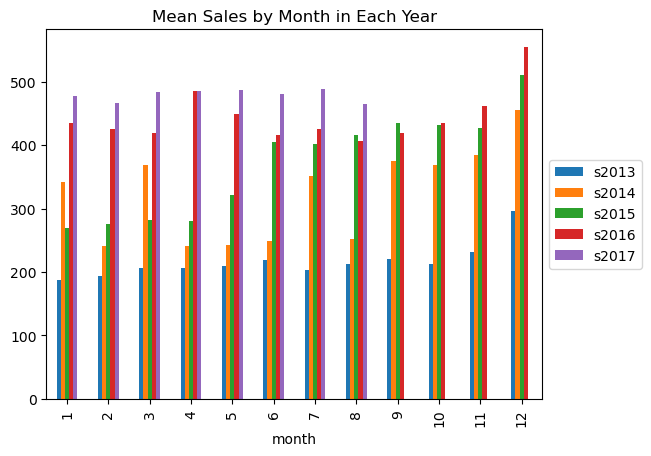

In [46]:
_ = df_year.set_index('month').plot.bar()
_ = plt.title('Mean Sales by Month in Each Year')
_ = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## 3.5 Save Data<a id='3.5'></a>

In [47]:
datapath = '../data'
save_file(df_train, 'train_all_groups.csv', datapath)
save_file(grp_sel_filled, 'train_selected_group.csv', datapath)

Writing file.  "../data/train_all_groups.csv"
Writing file.  "../data/train_selected_group.csv"


## 3.6 Summary<a id='3.6'></a>

Missing values and time gaps in the data were filled.

Store sales data were merged with possible exogenous varibles.

There were 54x33=1782 time series, and the one with store_nbr = 44 and product_family = "Grocery I" was selected for baseline modeling because it had highest mean sales.